In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt

%matplotlib inline

from torch.utils.data import DataLoader, ConcatDataset
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.utils import save_image
from tqdm.notebook import tqdm

In [2]:
import warnings

warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
%cd '/content/gdrive/My Drive/generate'

/content/gdrive/My Drive/generate


In [5]:
IMAGE_DIR = 'data'
RESULTS_DIR = 'output'

image_size = 64
batch_size = 16

normalization_stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
normal_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*normalization_stats)
]))

mirror_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.RandomHorizontalFlip(p=1.0),
    T.ToTensor(),
    T.Normalize(*normalization_stats)
]))

color_jitter_dataset = ImageFolder(IMAGE_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ColorJitter(0.5, 0.5, 0.5),
    T.ToTensor(),
    T.Normalize(*normalization_stats)
]))

dataset_list = [normal_dataset, mirror_dataset, color_jitter_dataset]
dataset = ConcatDataset(dataset_list)

dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=4, pin_memory=False)

In [7]:
def denorm(image):
    return image * normalization_stats[1][0] + normalization_stats[0][0]

In [8]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(16, 16))
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))
    
def show_batch(dataloader, nmax=64):
    for images, _ in dataloader:
        show_images(images, nmax)
        break

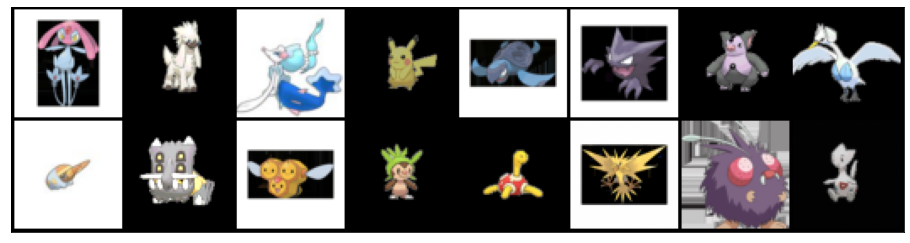

In [9]:
show_batch(dataloader)

In [10]:
discriminator = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    
    nn.Conv2d(128, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    nn.Conv2d(128, 1, kernel_size=4, stride=1, padding=0, bias=False),
    nn.Flatten(),
    nn.Sigmoid()
)

In [11]:
generator = nn.Sequential(
    nn.ConvTranspose2d(16, 128, kernel_size=4, padding=0, stride=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128, 128, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(128, 64, kernel_size=4, padding=1, stride=2, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    
    nn.ConvTranspose2d(64, 3, kernel_size=4, padding=1, stride=2, bias=False),
    nn.Tanh()
)

In [12]:
def get_training_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    def __init__(self, dataloader, device):
        self.dataloader = dataloader
        self.device = device
        
    def __iter__(self):
        for b in self.dataloader: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dataloader)

In [13]:
device = get_training_device()
dev_dataloader = DeviceDataLoader(dataloader, device)

discriminator = to_device(discriminator, device)
generator = to_device(generator, device)

device

device(type='cuda')

In [14]:
def train_discriminator(real_pokemon, disc_optimizer):
    disc_optimizer.zero_grad()
    
    real_predictions = discriminator(real_pokemon)
    real_targets = torch.rand(real_pokemon.size(0), 1, device=device) * (0.1 - 0) + 0
    real_loss = F.binary_cross_entropy(real_predictions, real_targets)
    real_score = torch.mean(real_predictions).item()

    latent_batch = torch.randn(batch_size, 16, 1, 1, device=device)

    fake_pokemon = generator(latent_batch)

    gen_predictions = discriminator(fake_pokemon)
    gen_targets = torch.rand(fake_pokemon.size(0), 1, device=device) * (1 - 0.9) + 0.9
    gen_loss = F.binary_cross_entropy(gen_predictions, gen_targets)
    gen_score = torch.mean(gen_predictions).item() 

    total_loss = real_loss + gen_loss
    total_loss.backward()
    disc_optimizer.step()
    
    return total_loss.item(), real_score, gen_score

In [15]:
def train_generator(gen_optimizer):
    gen_optimizer.zero_grad()

    latent_batch = torch.randn(batch_size, 16, 1, 1, device=device)
    fake_pokemon = generator(latent_batch)

    disc_predictions = discriminator(fake_pokemon)
    targets = torch.zeros(fake_pokemon.size(0), 1, device=device)
    loss = F.binary_cross_entropy(disc_predictions, targets)
    loss.backward()
    gen_optimizer.step()

    return loss.item()

In [16]:
def save_results(index, latent_batch, show=True):
    fake_pokemon = generator(latent_batch)
    fake_file = "{0:0=4d}.png".format(index)
    
    save_image(denorm(fake_pokemon), os.path.join(RESULTS_DIR, fake_file), nrow=8)
    print("Results Saved")
    
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        
        ax.set_xticks([])
        ax.set_yticks([])
        
        ax.imshow(make_grid(fake_pokemon.cpu().detach(), nrow=8).permute(1, 2, 0))

In [17]:
fixed_latent_batch = torch.randn(64, 16, 1, 1, device=device)

def train(epochs, learning_rate, start_idx=1):
    torch.cuda.empty_cache()

    disc_losses = []
    disc_scores = []
    gen_losses = []
    gen_scores = []
    
    disc_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate, betas=(0.5, 0.9))
    
    for epoch in range(epochs):
        for real_img, _ in tqdm(dev_dataloader):
            disc_loss, real_score, gen_score = train_discriminator(real_img, disc_optimizer)
            gen_loss = train_generator(gen_optimizer)

        disc_losses.append(disc_loss)
        disc_scores.append(real_score)
        gen_losses.append(gen_loss)
        gen_scores.append(gen_score)
        
        print("Epoch [{}/{}], gen_loss: {:.4f}, disc_loss: {:.4f}, real_score: {:.4f}, gen_score: {:.4f}".format(
            epoch + start_idx, epochs, gen_loss, disc_loss, real_score, gen_score))
        
        save_results(epoch + start_idx, fixed_latent_batch, show=False)
    
    return disc_losses, disc_scores, gen_losses, gen_scores

In [ ]:
learning_rate = 0.0025
epochs = 50

history = train(epochs, learning_rate)